# 

# Experiment tracking

Durante este proceso registraremos modelos, hiperparametros, metricas, entre otras cosas (horrible esto ultimo "cosas", ¿qué cosas?, de momento no encontre mejor definición) que nos permitirán saber que modelo comple mejor con nuestro objetivo.

Podrémos de esta manera separar los modelos que funcionan con los que no.

Las maneras de realizar este proceso son varias, las contempladas por el curso son las siguientes:
<center><img src="img/experiment_tracking.png" alt="Experiment tracking"></center>
Dado que el ML y DL se basan principalmente en experimentación no esta demás ejemplificar con programación un algoritmo de experiment tracking.

Algunos recursos interesanets son los siguientes:
- https://www.learnpytorch.io/07_pytorch_experiment_tracking/
- http://madewithml.com/

In [1]:
# Librerias principales a utilizar:

import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

In [2]:
import os
import zipfile
import requests
from pathlib import Path

def download_data(source: str,
                  destionation: str,
                  remove_source: bool = True) -> Path:
    """ Esta función descargará un archivo comprimido indicando su ruta de imagen y la descromprimirá en una ruta de destino"""
    data_path = Path("data/")
    image_path = data_path / destionation

    if image_path.is_dir():
        print(f"El directorio de: {image_path} ya existe, no hace falta descargar nada")
    else:
        print(f"Descargando... ... ...")
        image_path.mkdir(parents=True, exist_ok=True)

        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"Descargando {target_file} de {source}...")
            f.write(request.content)

        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"Descomprimiento {target_file}")
            zip_ref.extractall(image_path)

        if remove_source:
            os.remove(data_path / target_file)
            
    return image_path

In [3]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip",
                           destionation="pizza_stake_sushi",
                           remove_source=True)

# image_path

El directorio de: data\pizza_stake_sushi ya existe, no hace falta descargar nada


In [4]:
from torchvision import transforms

normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

manual_transforms


Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

- https://docs.pytorch.org/vision/main/models.html

In [5]:
train_dir = image_path / "train"
test_dir = image_path / "test"

import torchvision
weigths = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# transform
automatic_transforms = weigths.transforms()
print(f"Automatic creatd transforms: {automatic_transforms}")
# dataloader
from going_modular.going_modular import data_setup

train_data_loader, test_data_loader, classes_names = data_setup.create_dataloaders(train_dir=train_dir, 
                                                                                   test_dir=test_dir,
                                                                                   transform=manual_transforms,
                                                                                   batch_size=32)

Automatic creatd transforms: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


In [6]:
weigths = torchvision.models.EfficientNet_B0_Weights.DEFAULT

model = torchvision.models.efficientnet_b0(weights=weigths) 
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [7]:
for param in model.features.parameters():
    # print(param)
    param.requires_grad = False

In [8]:
model.classifier 
# Debemos realizar algunos ajustes

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [9]:
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(classes_names))
)

In [10]:
from torchinfo import summary

summary(model,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

Entrenando nuestro modelo...

Recordar la documentación asociada: https://www.tensorflow.org/tensorboard?hl=es-419

In [11]:
# Función de perdida y optimización:

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [12]:
# Resumen de nuestro modelo en un objeto Writer
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir="runs/entrenamiento1")
writer

In [13]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

from going_modular.going_modular.engine import train_step, test_step

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]} 
    For example if training for epochs=2: 
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    
    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        # Experiment tracking, la documentación es de locos
        writer.add_scalars(main_tag="Loss",
                           tag_scalar_dict={"train_loss": train_loss,
                                            "test_loss": test_loss},
                                            global_step=epoch)
        writer.add_scalars(main_tag="Accuracy",
                           tag_scalar_dict={"train_acc": train_acc,
                                            "train_loss": test_acc},
                            global_step=epoch)
        
        writer.add_graph(model=model,
                         input_to_model=torch.randn(32, 3, 224, 224))
        
        # Debemos cerrar el writer, así como en Java...
        writer.close()
    # Return the filled results at the end of the epochs
    return results

c:\Users\marti\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
# No podemos usar engine.train() hasta no actualizar train()
results = train(model=model,
                train_dataloader=train_data_loader,
                test_dataloader=test_data_loader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=5,
                device="cpu")

  0%|          | 0/5 [00:00<?, ?it/s]c:\Users\marti\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch: 1 | train_loss: 1.0288 | train_acc: 0.5352 | test_loss: 0.9528 | test_acc: 0.5994


 20%|██        | 1/5 [00:48<03:13, 48.26s/it]

Epoch: 2 | train_loss: 0.8385 | train_acc: 0.6680 | test_loss: 0.8575 | test_acc: 0.6098


 40%|████      | 2/5 [01:33<02:18, 46.20s/it]

Epoch: 3 | train_loss: 0.8356 | train_acc: 0.6367 | test_loss: 0.7634 | test_acc: 0.7746


 60%|██████    | 3/5 [02:19<01:32, 46.29s/it]

Epoch: 4 | train_loss: 0.6802 | train_acc: 0.7695 | test_loss: 0.6591 | test_acc: 0.9072


 80%|████████  | 4/5 [03:05<00:46, 46.26s/it]

Epoch: 5 | train_loss: 0.6138 | train_acc: 0.9414 | test_loss: 0.5792 | test_acc: 0.9072


100%|██████████| 5/5 [03:53<00:00, 46.70s/it]


# Visualizar los resultados con TensorBoard

In [15]:
%load_ext tensorboard
%tensorboard --logdir=runs

# %reload_ext tensorboard

Reusing TensorBoard on port 6008 (pid 17200), started 1 day, 20:54:12 ago. (Use '!kill 17200' to kill it.)

La verdad no entiendo nada del gráfico, ni de nada creo, pero bueno será practica y horas de sentarse a analizar modelos... la visión de la arquitectura es una completa locura, podemos bajar y bajar y bajar...

# Creamos una función para intanciar SummaryWriter()

De manera default nuestro objeto o clase SummaryWriter() guarda nuestro log_dir, el problema surge cuando queremos guardar diferentes experimentos sobre nuestros modelos en diferentes carpetas.

Una manera muy interesante de guardar de tal manera que puedan ser identificables de una muy buena manera es la siguiente:

runs/YYYY-MM-DD/experiment_name/model_name/extra

In [16]:
# from datetime import datetime
# timestamp = datetime.now().strftime("%Y-%m-%d")
# timestamp

In [17]:
from torch.utils.tensorboard import SummaryWriter

def create_writer(experiment_name: str,
                  model_name: str,
                  extra: str = None):
    """Crearemos una instancia torch.utils.tensorboard.writer.SummaryWriter() que tomará un nombre especifico acorde a un directorio runs / fecha / nombre del experimento / nombre del modelo / extra"""
    from datetime import datetime
    import os

    timestamp = datetime.now().strftime("%Y-%m-%d")

    if extra:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
    
    return SummaryWriter(log_dir = log_dir)
    

In [18]:
example_writer = create_writer(experiment_name="entrenamiento1",
                               model_name="effnetb0",
                               extra="5_epocas")

example_writer

# Actualizar train() incluyendo un parametro *writer*

In [19]:
import torch.utils.tensorboard


def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          writer: torch.utils.tensorboard.writer.SummaryWriter) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]} 
    For example if training for epochs=2: 
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    
    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        if writer:
            # Experiment tracking, la documentación es de locos
            writer.add_scalars(main_tag="Loss",
                              tag_scalar_dict={"train_loss": train_loss,
                                                "test_loss": test_loss},
                                                global_step=epoch)
            writer.add_scalars(main_tag="Accuracy",
                              tag_scalar_dict={"train_acc": train_acc,
                                                "train_loss": test_acc},
                                global_step=epoch)
            
            writer.add_graph(model=model,
                            input_to_model=torch.randn(32, 3, 224, 224))
            
            # Debemos cerrar el writer, así como en Java...
            writer.close()
        else:
            pass

    # Return the filled results at the end of the epochs
    return results

# ¿Qué tipo de experimentos podrémos realizar?

Tantos modelos de ML/DL como experimentos, infinitos...

¿Cómo podrémos realizar esto...?
 
- Cambiando el número de epocas
- Cambiando el número de capas ocultas
- Cambiando la cantidad de datos de entrenamiento, aunque recordemos que esto no necesariamente es traducido como una mejora a nuestro modelo...
- Cambiando el learning rate (lr)
- Usando tecnicas tales como data augmentation
- Eligiendo otras arquitecturas.

Esto es infinito, es imposible contamplar en un curso o en una vida incluso todos y cada uno de los modelos posibles, sean o no utiles, por eso lo mejor es aprender los conceptos claves, establecer una logica y forma de trabajar y programar y programar y... programar.

# Probarémos entonces...
1. Cambiar el tamaño del modelo - EffnetB0 vs EffnetB2
2. Cambiarémos el tamaño del set de datos, recomendemos que hasta ahora usamos el 10%, usarémos el 20% también, generalmente más datos, mejor exactitud, aunque esto no siempre es así.
3. Cambiarémos la cantidad de épocas, generalmente mientras más epocas más exactitud, aunque recordemos que esta regla no es para todos los casos tal como se vio al comienzo con un modelo lineal que, sea lo que sea entrenado, jamas lograría resolver correctamente nuestro problema.

# Esto nos permitirá entonces...

Crear un modelo que cumpla con su función pero sea lo más pequeño posible, según el curso esto debería darse de tal manera que pueda ser ejecutado en un navegador... como idea a futuro quiero realizar con HTML, CSS, JS y YOLO un piedra, papel o tijera a distancia que conste en cuestión de una red que identifique las manos, aunque sobre esto no tengo idea y no me quiero ir de tema...

In [20]:
# Descarguemos entonces los set de datos...
data_10_percent = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/data/pizza_steak_sushi.zip",
                                destionation="pizza_stake_sushi")

El directorio de: data\pizza_stake_sushi ya existe, no hace falta descargar nada


In [21]:
data_20_percent = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                destionation="pizza_stake_sushi_20_percent")

El directorio de: data\pizza_stake_sushi_20_percent ya existe, no hace falta descargar nada


In [22]:
# Transformemos los set de datos en DataLoaders

# Creamos los directorios de entrenamiento y prueba

train_dir_10_percent = data_10_percent / "train"
train_dir_20_percent = data_20_percent / "train"

test_dir_10_percent = data_10_percent / "test"
test_dir_20_percent = data_10_percent / "test"

train_dir_10_percent, train_dir_20_percent, test_dir_10_percent, test_dir_20_percent

(WindowsPath('data/pizza_stake_sushi/train'),
 WindowsPath('data/pizza_stake_sushi_20_percent/train'),
 WindowsPath('data/pizza_stake_sushi/test'),
 WindowsPath('data/pizza_stake_sushi/test'))

In [23]:
# Normalizamos y creamos los Transforms

from torchvision import transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

simple_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

In [24]:
BATCH_SIZE = 32

# 10% test y DataLoader: 
train_data_loader_10_percent, test_data_loader, class_names = data_setup.create_dataloaders(train_dir=train_dir_10_percent, 
                                                                                              test_dir=test_dir,
                                                                                              transform=simple_transform,
                                                                                              batch_size=BATCH_SIZE)

# 20% test y DataLoader:
train_data_loader_20_percent, test_data_loader, class_names = data_setup.create_dataloaders(train_dir=train_dir_10_percent, 
                                                                                              test_dir=test_dir,
                                                                                              transform=simple_transform,
                                                                                              batch_size=BATCH_SIZE)

print(f"Número de lotes de tamaño {BATCH_SIZE} en los datos de entrenamiento al 10%: {len(train_data_loader_10_percent)}")
print(f"Número de lotes de tamaño {BATCH_SIZE} en los datos de entrenamiento al 20%: {len(train_data_loader_20_percent)}")
print(f"Número de lotes de tamaño {BATCH_SIZE} en los datos de prueba: {len(test_data_loader)} (todos los experimentos usarán el mismo conjunto de prueba)")
print(f"Número de clases: {len(class_names)}, nombres de las clases: {class_names}")

Número de lotes de tamaño 32 en los datos de entrenamiento al 10%: 8
Número de lotes de tamaño 32 en los datos de entrenamiento al 20%: 8
Número de lotes de tamaño 32 en los datos de prueba: 3 (todos los experimentos usarán el mismo conjunto de prueba)
Número de clases: 3, nombres de las clases: ['pizza', 'steak', 'sushi']


# Modelos extractores de atributos o características (features)

Creamos dos funciones:

- Una para crear `torchvision.models.efficientnet_b0()` con una cantidad de capas de entrada fija y una de salida personalizada.
- Una para crear `torchvision.models.efficientnet_b2()` con una cantidad de capas de entrada fija y una de salida personalizada.

In [25]:
import torchvision

effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

effnetb2

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [26]:
from torch import nn

OUT_FEATURES = len(class_names)

def create_effnetb0():

    # Inicilizamos los pesos y el modelo:

    weigths = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weigths)
    
    for param in model.features.parameters():
        param.requires_grad = False
    
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=1280, out_features=OUT_FEATURES)
    )

    model.name = "effnetb0"
    print(f"Creando {model.name}")
    return model

In [27]:
# created_model_test = create_effnetb0()

In [35]:
def create_effnetb2():

    # Inicilizamos los pesos y el modelo:

    weigths = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weigths)
    
    for param in model.features.parameters():
        param.requires_grad = False
    
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features=1408, out_features=OUT_FEATURES)
    )

    model.name = "effnetb2"
    print(f"Creando {model.name}...")
    return model

In [29]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [30]:
# created_model_test = create_effnetb2()

In [31]:
effnetb0 = create_effnetb0() 

summary(model=effnetb0, 
         input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
         # col_names=["input_size"], # uncomment for smaller output
         col_names=["input_size", "output_size", "num_params", "trainable"],
         col_width=20,
         row_settings=["var_names"]
 ) 

Creando effnetb0


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [32]:
effnetb2 = create_effnetb2()

Creando effnetb2...


# Ahora bien, creemos experimentos... varios

In [39]:
# Lista de epocas

epocas = [5]

models = ["effnetb0", "effnetb2"]

train_data_loaders = {"data_10_percent": train_data_loader_10_percent,
                     "data_20_percent": train_data_loader_20_percent}

In [40]:
from going_modular.going_modular.utils import save_model
import torch
import torch.nn as nn

experiment_number = 0

# Iteramos por cada combinación
for data_loader_name, train_data_loader in train_data_loaders.items():
    for modelo_nombre in models:
        for num_epocas in epocas:
            
            experiment_number += 1
            print(f"Número de experimento: {experiment_number}")
            print(f"Nombre del dataloader: {data_loader_name}")
            print(f"Modelo: {modelo_nombre}")
            print(f"Épocas: {num_epocas}")

            # Crear modelo según el nombre
            if modelo_nombre == "effnetb0":
                modelo = create_effnetb0()
            elif modelo_nombre == "effnetb2":
                modelo = create_effnetb2()
            else:
                raise ValueError(f"Modelo no reconocido: {modelo_nombre}")
            print("Modelo creado")

            # Definir pérdida y optimizador
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=modelo.parameters(), lr=0.001)

            # Entrenar el modelo
            results = train(
                model=modelo,
                train_dataloader=train_data_loader,
                test_dataloader=test_data_loader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=num_epocas,
                device="cpu",
                writer=create_writer(
                    experiment_name=data_loader_name,
                    model_name=modelo.__class__.__name__,
                    extra=f"{num_epocas}_epocas"
                )
            )

            # Guardar el modelo
            save_file_path = f"09_{modelo_nombre}_{data_loader_name}_{num_epocas}_epocas.pth"
            save_model(model=modelo, target_dir="models", model_name=save_file_path)
            print(f"Modelo guardado en: {save_file_path}")
            print("=" * 50)


Número de experimento: 1
Nombre del dataloader: data_10_percent
Modelo: effnetb0
Épocas: 5
Creando effnetb0
Modelo creado


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1207 | train_acc: 0.3477 | test_loss: 0.9444 | test_acc: 0.5795


 20%|██        | 1/5 [00:43<02:55, 43.81s/it]

Epoch: 2 | train_loss: 0.9132 | train_acc: 0.6406 | test_loss: 0.8398 | test_acc: 0.7424


 40%|████      | 2/5 [01:23<02:03, 41.22s/it]

Epoch: 3 | train_loss: 0.8187 | train_acc: 0.7070 | test_loss: 0.6896 | test_acc: 0.8854


 60%|██████    | 3/5 [01:59<01:18, 39.10s/it]

Epoch: 4 | train_loss: 0.7366 | train_acc: 0.7773 | test_loss: 0.7045 | test_acc: 0.7936


 80%|████████  | 4/5 [02:36<00:38, 38.06s/it]

Epoch: 5 | train_loss: 0.6482 | train_acc: 0.7422 | test_loss: 0.6646 | test_acc: 0.8655


100%|██████████| 5/5 [03:13<00:00, 38.68s/it]


[INFO] Saving model to: models\09_effnetb0_data_10_percent_5_epocas.pth
Modelo guardado en: 09_effnetb0_data_10_percent_5_epocas.pth
Número de experimento: 2
Nombre del dataloader: data_10_percent
Modelo: effnetb2
Épocas: 5
Creando effnetb2...
Modelo creado


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0950 | train_acc: 0.3750 | test_loss: 0.9716 | test_acc: 0.6506


 20%|██        | 1/5 [00:51<03:26, 51.56s/it]

Epoch: 2 | train_loss: 0.8739 | train_acc: 0.7969 | test_loss: 0.8354 | test_acc: 0.8040


 40%|████      | 2/5 [01:39<02:27, 49.24s/it]

Epoch: 3 | train_loss: 0.8604 | train_acc: 0.6758 | test_loss: 0.7637 | test_acc: 0.8144


 60%|██████    | 3/5 [02:27<01:37, 48.63s/it]

Epoch: 4 | train_loss: 0.7336 | train_acc: 0.7617 | test_loss: 0.7338 | test_acc: 0.8466


 80%|████████  | 4/5 [03:12<00:47, 47.54s/it]

Epoch: 5 | train_loss: 0.6413 | train_acc: 0.7578 | test_loss: 0.6438 | test_acc: 0.9072


100%|██████████| 5/5 [03:59<00:00, 47.81s/it]


[INFO] Saving model to: models\09_effnetb2_data_10_percent_5_epocas.pth
Modelo guardado en: 09_effnetb2_data_10_percent_5_epocas.pth
Número de experimento: 3
Nombre del dataloader: data_20_percent
Modelo: effnetb0
Épocas: 5
Creando effnetb0
Modelo creado


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0330 | train_acc: 0.4805 | test_loss: 0.8657 | test_acc: 0.7017


 20%|██        | 1/5 [00:39<02:37, 39.40s/it]

Epoch: 2 | train_loss: 0.8555 | train_acc: 0.7031 | test_loss: 0.8007 | test_acc: 0.6913


 40%|████      | 2/5 [01:22<02:05, 41.77s/it]

Epoch: 3 | train_loss: 0.7278 | train_acc: 0.7734 | test_loss: 0.7311 | test_acc: 0.7936


 60%|██████    | 3/5 [02:02<01:21, 40.78s/it]

Epoch: 4 | train_loss: 0.7274 | train_acc: 0.7148 | test_loss: 0.6517 | test_acc: 0.8655


 80%|████████  | 4/5 [02:40<00:39, 39.78s/it]

Epoch: 5 | train_loss: 0.6045 | train_acc: 0.7773 | test_loss: 0.5504 | test_acc: 0.8864


100%|██████████| 5/5 [03:20<00:00, 40.10s/it]


[INFO] Saving model to: models\09_effnetb0_data_20_percent_5_epocas.pth
Modelo guardado en: 09_effnetb0_data_20_percent_5_epocas.pth
Número de experimento: 4
Nombre del dataloader: data_20_percent
Modelo: effnetb2
Épocas: 5
Creando effnetb2...
Modelo creado


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0687 | train_acc: 0.3906 | test_loss: 1.0008 | test_acc: 0.6402


 20%|██        | 1/5 [00:48<03:14, 48.56s/it]

Epoch: 2 | train_loss: 0.8862 | train_acc: 0.7617 | test_loss: 0.8881 | test_acc: 0.7027


 40%|████      | 2/5 [01:36<02:25, 48.35s/it]

Epoch: 3 | train_loss: 0.7951 | train_acc: 0.7227 | test_loss: 0.8120 | test_acc: 0.8153


 60%|██████    | 3/5 [02:26<01:38, 49.14s/it]

Epoch: 4 | train_loss: 0.7100 | train_acc: 0.7578 | test_loss: 0.7483 | test_acc: 0.8466


 80%|████████  | 4/5 [03:10<00:47, 47.10s/it]

Epoch: 5 | train_loss: 0.6450 | train_acc: 0.7656 | test_loss: 0.6906 | test_acc: 0.8665


100%|██████████| 5/5 [04:00<00:00, 48.01s/it]

[INFO] Saving model to: models\09_effnetb2_data_20_percent_5_epocas.pth
Modelo guardado en: 09_effnetb2_data_20_percent_5_epocas.pth


# Ya teniendo 4 experimentos podrémos ahora si visualizar estos en TensorBoard...

In [42]:
%load_ext tensorboard
%tensorboard --logdir runs/
%reload_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 2616), started 0:00:06 ago. (Use '!kill 2616' to kill it.)

# Utilicemos entonces el modelo más eficiente junto al experimento más eficiente con sus caracteristicas ya entrenadas...
El modelo más eficiente es el data_10_percent, usarémos ese.

Hice algo mal dado que no me dice que modelo uso... si le b0 o b2 en el TensorBoard...

Esto esta mal, si estoy entendiendo bien tengo guardado en un mismo directorio muchos experimentos y esto hace que todos se muestren, acá me pierdo y hago cagadas. Además de haber guardado mal ciertos nombres, effnetb0 se usa pero effnetb2 no, no entiendo porque... me llevo el concepto pero tengo que mejorar esto...

In [ ]:
# Establecemos la ruta de nuestro experimento...

best_model_path = "models/09_effnetb2_data_20_percent_5_epocas.pth"

# Creamos el modelo
best_model = create_effnetb2()

# Cargamos los datos de nuestro experimento previament realizado, esto puede aplicarse con experimentos que no hicimos incluso, es una cosa de locos
best_model.load_state_dict(torch.load(best_model_path))

Creando effnetb2...


<All keys matched successfully>

In [45]:
from pathlib import Path

effnetb2_model_size = Path(best_model_path).stat().st_size // (1024*1014) # Convertido a MB
print(f"El modelo pesa: {effnetb2_model_size} MB")

El modelo pesa: 30 MB


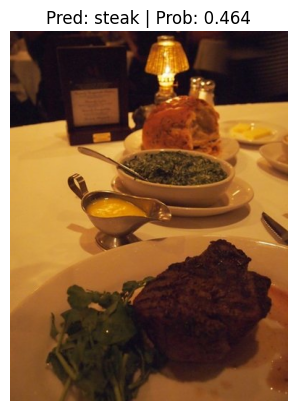

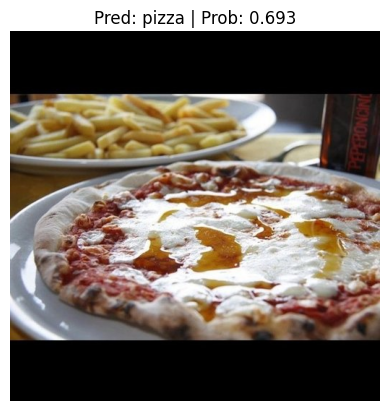

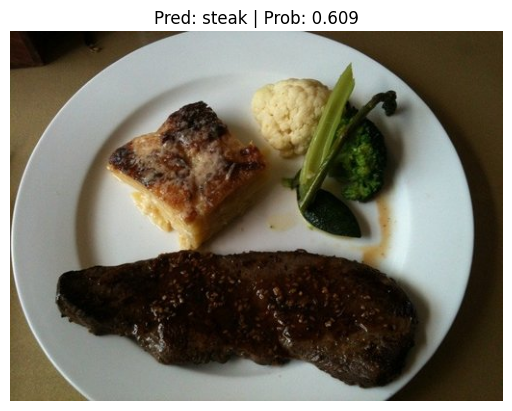

In [47]:
from going_modular.going_modular.predictions import pred_and_plot_image

import random
num_image_to_plot = 3
test_image_path_list = list(Path(data_20_percent / "test").glob("*/*.jpg"))
test_image_path_sample = random.sample(test_image_path_list,
                                       k=num_image_to_plot)

for image_path in test_image_path_sample:
    pred_and_plot_image(model=best_model,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224, 224))